In [1]:
%matplotlib inline
import math
import numpy as np
import scipy
from scipy.stats import binom, hypergeom
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

# Matching

READ two feature sets: 
- DT_base
- DT_cplx

In [9]:
## read "DT_base" -- DT with basic features
DT_base = pd.read_csv('./Test_data/src_data/DT_base.csv')
print(DT_base.head())

## read "DT_cplx" -- DT with complex features
DT_cplx = pd.read_csv('./Test_data/src_data/DT_cplx.csv')
DT_cplx.head()

#### DT_m: merge DT_base and DT_cplx
colnames = DT_base.keys()
DT_m = DT_base.loc[:, colnames[1:-1]]  #-- all features
# merge with DT_cplx
DT_m = pd.concat([DT_m, DT_cplx['abstract_topic']], axis = 1)

DT_y = DT_base['n_citation']           #-- only outcome-n_citation

   n_citation  group  title_len  abs_len  no_author  no_ref
0           1      1          7       95         19     168
1           0      1         11      104         95     264
2           9      1          7      201         33     405
3           6      1          9      226         52     143
4           2      1          7       94         16     155


In [14]:
DT_m.head()

,group,title_len,abs_len,no_author,abstract_topic
0,1,7,95,19,0
1,1,11,104,95,0
2,1,7,201,33,0
3,1,9,226,52,1
4,1,7,94,16,0


In [16]:
DT_y.head()

0    1
1    0
2    9
3    6
4    2
Name: n_citation, dtype: int64

## Method - use NearestNeighbors from sklearn
- Reference: https://stats.stackexchange.com/questions/206832/matched-pairs-in-python-propensity-score-matching

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

def get_matching_pairs(treated_df, non_treated_df, scaler=True):

    treated_x = treated_df.values
    non_treated_x = non_treated_df.values
    if scaler == True:
        scaler = StandardScaler()
    if scaler:
        scaler.fit(treated_x)
        treated_x = scaler.transform(treated_x)
        non_treated_x = scaler.transform(non_treated_x)

    nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(non_treated_x)
    distances, indices = nbrs.kneighbors(treated_x)
    indices = indices.reshape(indices.shape[0])
    matched = non_treated_df.iloc[indices ]
    # add indices
    matched['idx'] = indices
    
    return matched

In [28]:
sel_cols = list(colnames[2:-1])
sel_cols.append('abstract_topic')

treated_df = DT_m.loc[ DT_m['group'] == 1,  sel_cols]
non_treated_df = DT_m.loc[ DT_m['group'] == 0,  sel_cols]
print("Before matching: ", treated_df.shape, non_treated_df.shape)

## apply "get_matching_pairs()"
matched_df = get_matching_pairs(treated_df, non_treated_df)
## adjust idx
matched_df.loc[:, 'idx'] = matched_df['idx'].apply(lambda x: x + len(treated_df))


## get the DV: n_citation for "matched_df" (merge with DT_y)
matched_df['group'] = 0
matched_df['n_citation'] = matched_df['idx'].apply(lambda x: DT_y.iloc[x])
matched_df = matched_df.drop(columns = "idx")


## get the DV: n_citation for "treated_df"
treated_df['group'] = 1
treated_df['n_citation'] = DT_y.iloc[0:len(treated_df)]

print("After matching:  ", matched_df.shape, treated_df.shape)
matched_df.head()

Before matching:  (4571, 4) (3519, 4)
After matching:   (4571, 6) (4571, 6)


C:\Users\chenj107\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\chenj107\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
C:\Users\chenj107\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

,title_len,abs_len,no_author,abstract_topic,group,n_citation
4696,7,90,25,0,0,19
6341,11,103,87,0,0,3
7740,7,202,28,0,0,6
7151,9,228,52,1,0,9
7332,7,103,20,0,0,1


In [29]:
treated_df.head()

,title_len,abs_len,no_author,abstract_topic,group,n_citation
0,7,95,19,0,1,1
1,11,104,95,0,1,0
2,7,201,33,0,1,9
3,9,226,52,1,1,6
4,7,94,16,0,1,2


**Visualization** -- before/after matching

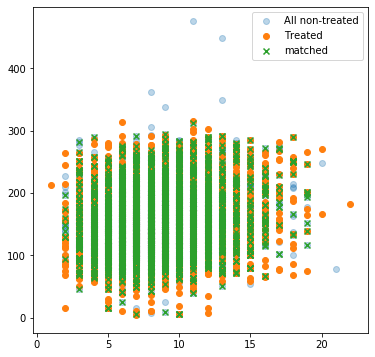

In [31]:
fig, ax = plt.subplots(figsize=(6,6))
plt.scatter(non_treated_df['title_len'], non_treated_df['abs_len'], alpha=0.3, label='All non-treated')
plt.scatter(treated_df['title_len'], treated_df['abs_len'], label='Treated')
plt.scatter(matched_df['title_len'], matched_df['abs_len'], marker='x', label='matched')
plt.legend()
# plt.xlim(-1,2)

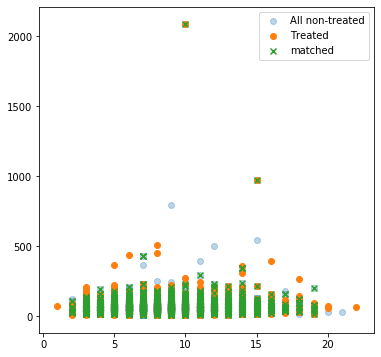

In [32]:
fig, ax = plt.subplots(figsize=(6,6))
plt.scatter(non_treated_df['title_len'], non_treated_df['no_author'], alpha=0.3, label='All non-treated')
plt.scatter(treated_df['title_len'], treated_df['no_author'], label='Treated')
plt.scatter(matched_df['title_len'], matched_df['no_author'], marker='x', label='matched')
plt.legend()

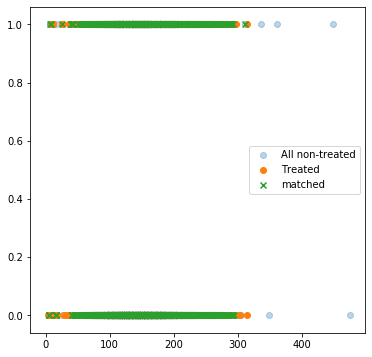

In [34]:
fig, ax = plt.subplots(figsize=(6,6))
plt.scatter(non_treated_df['abs_len'], non_treated_df['abstract_topic'], alpha=0.3, label='All non-treated')
plt.scatter(treated_df['abs_len'], treated_df['abstract_topic'], label='Treated')
plt.scatter(matched_df['abs_len'], matched_df['abstract_topic'], marker='x', label='matched')
plt.legend()